From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from methods import *
from utils import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [41]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name='MNIST'

In [19]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name = 'FMNIST'

Running on cpu.
Model weights loaded successfully


In [2]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name = 'ResNet'

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [3]:
hist_dfs = []
final_hist_dfs = []
hist = None

debug = True
targeted = True
epsilon = 0.005
ex_savers = []
# Run test for each epsilon
#algs = ['fw', 'fw_away', 'fw_pair']
algs = ['fw']
for alg in algs:
    ex_saver = example_saver()
    acc, ex, hist = test(target_mdl, device,
                         epsilon = epsilon, 
                         num_fw_iter = 20,
                         method = alg, 
                         early_stopping = 'gap_FW', 
                         fw_stepsize_rule = 'decay', 
                         gap_FW_tol = 0.1,
                         targeted = targeted, 
                         num_test = 100, 
                         ex_saver=ex_saver,
                         norm_p=-1, # -1 for infnty norm
                         seed=11)
    ex_savers.append(ex_saver)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

  1%|          | 109/10000 [00:26<39:24,  4.18it/s] 

Epsilon: 0.005	Correct Classifications (Failed Attacks) = 34 / 100 = 0.34


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,adv_target,stepsize,l_inf,mdlLoss,targeted_success
19,0,20,0.159364,True,True,9,8,max_iter,8,0.095238,0.005,0.967696,True
39,1,20,0.134673,False,False,6,6,max_iter,8,0.095238,0.005,6.308398,False
59,2,20,0.297363,False,False,0,0,max_iter,8,0.095238,0.005,3.279104,False
64,3,5,0.063823,True,False,1,9,gap,9,0.333333,0.005,0.098498,True
68,4,4,0.004122,True,False,7,3,gap,3,0.400000,0.005,0.001360,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,95,3,0.085076,True,False,6,3,gap,3,0.500000,0.005,0.024956,True
1281,96,20,0.180326,True,False,8,7,max_iter,7,0.095238,0.005,0.612850,True
1301,97,20,0.173034,False,False,1,1,max_iter,5,0.095238,0.005,6.205026,False
1321,98,20,0.200978,False,False,7,7,max_iter,0,0.095238,0.005,4.948810,False


fw
	Attack Success Rate: 0.63
	Avg iters: 13.26


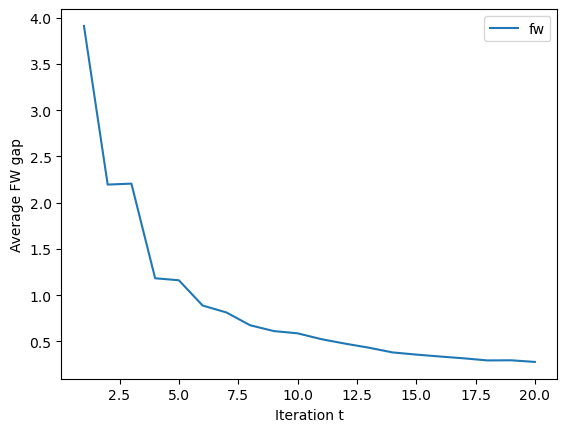

In [4]:

for i, final_hist in enumerate(final_hist_dfs):
    alg = algs[i]
    print(alg)
    print(f"\tAttack Success Rate: {final_hist['targeted_success' if targeted else 'success'].mean()}")
    print(f"\tAvg iters: {final_hist['FW_iter'].mean()}")
    if alg == 'fw_away':
        st = hist_dfs[i].groupby('step_type').size().to_dict()
        print(f"\tstep types: FW {st['FW']}, AS {st['AS']}")
    plt.plot(hist_dfs[i].groupby('FW_iter')['gap_FW'].mean(), label=algs[i])
plt.xlabel("Iteration t")
plt.ylabel("Average FW gap")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


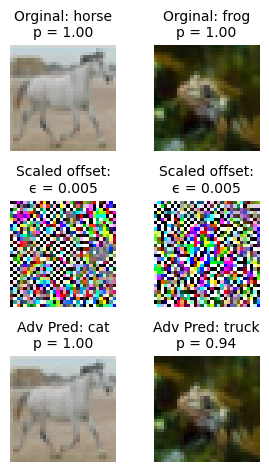

In [14]:
ex_saver = ex_savers[0]
n_col = 2
offset = 2
n_col = min(n_col, len(ex_saver.adv_pred))

fig, axs = plt.subplots(3,n_col)
for i in range(n_col):
    ex_idx = i + offset
    true = ex_saver.adv_true[ex_idx]
    pred = ex_saver.adv_pred[ex_idx]
    x0 = ex_saver.adv_x0[ex_idx]
    atk = (ex_saver.adv_atk[ex_idx]+epsilon)/(2*epsilon)
    atk = np.clip(atk,0,1)
    xt = ex_saver.adv_xt[ex_idx]
    prob_true = ex_saver.adv_true_init_prob[ex_idx]
    prob_adv = ex_saver.adv_final_prob[ex_idx]
    axs[0, i].imshow(x0)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Orginal: {target_mdl.classes[true]}\np = {prob_true:.2f}", fontsize=10)
    axs[1, i].imshow(atk)
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Scaled offset:\nϵ = {epsilon}", fontsize=10)
    axs[2, i].imshow(xt)
    axs[2, i].axis('off')
    axs[2, i].set_title(f"Adv Pred: {target_mdl.classes[pred]}\np = {prob_adv:.2f}", fontsize=10)
plt.tight_layout(pad=1.0, w_pad=-15, h_pad=1.0)
plt.show()

In [ ]:
np.save(f'atk_{mdl_name}_true{true}_pred{pred}',atk)

Epsilion choice analysis

In [11]:
with open('Report/Results/eps_compare.tsv','a') as f:
    header = ['eps', 'alg', 'SR', 'DS', 'targeted']
    targeted = False
    #f.write('\t'.join(header)+'\n')
    for i, df in enumerate(final_hist_dfs):
        f.write('\t'.join([str(epsilons[i]), alg, str(df['success'].mean()), mdl_name, str(targeted)])+'\n')

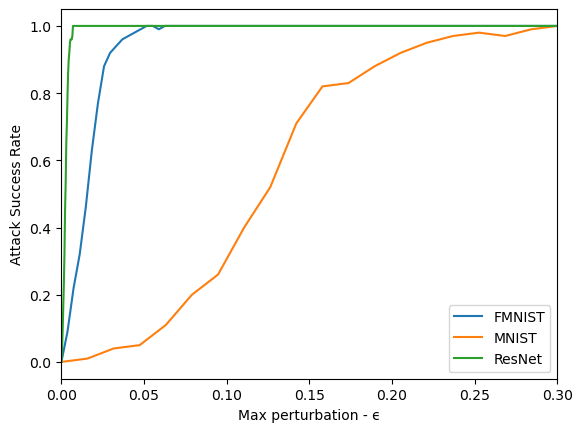

In [35]:
eps_df = pd.read_csv('Report/Results/eps_compare.tsv', sep='\t')
for ds in eps_df['DS'].unique():
    df = eps_df[eps_df['DS'] == ds]
    #df = df[df['eps'] <= 0.3]
    plt.plot(df['eps'], df['SR'], label=ds)
plt.xlim((0,0.3))
plt.legend()
plt.xlabel('Max perturbation - ϵ')
plt.ylabel('Attack Success Rate')
plt.savefig('Report/plots/eps_choice.png')
plt.show()


In [10]:
final_hist.groupby('stop_cond').size()

stop_cond
gap         27
max_iter    23
dtype: int64

In [53]:
mx_itr = final_hist[final_hist['stop_cond'] == 'max_iter']
print(f"Num max iter {len(mx_itr)}")
print(f"Targeted success {mx_itr['targeted_success'].mean()}")
mx_itr

Num max iter 14
Targeted success 0.42857142857142855


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,adv_target,stepsize,l_inf,mdlLoss,targeted_success
116,4,50,0.174891,True,False,5,8,max_iter,8,0.039216,0.005,0.960025,True
166,5,50,0.126219,False,False,4,4,max_iter,8,0.039216,0.005,4.913616,False
216,6,50,0.235349,False,False,6,6,max_iter,4,0.039216,0.005,4.194080,False
334,10,50,0.132843,True,False,9,5,max_iter,5,0.039216,0.005,0.932997,True
384,11,50,0.164530,False,False,2,2,max_iter,1,0.039216,0.005,1.345232,False
443,14,50,0.122660,False,False,7,7,max_iter,0,0.039216,0.005,4.526424,False
493,15,50,0.182795,False,False,8,8,max_iter,6,0.039216,0.005,4.635984,False
667,27,50,0.185479,False,False,3,3,max_iter,8,0.039216,0.005,1.587602,False
721,29,50,0.294661,False,False,8,8,max_iter,0,0.039216,0.005,3.690810,False
803,33,50,0.119805,True,False,2,4,max_iter,4,0.039216,0.005,0.726615,True


<Axes: >

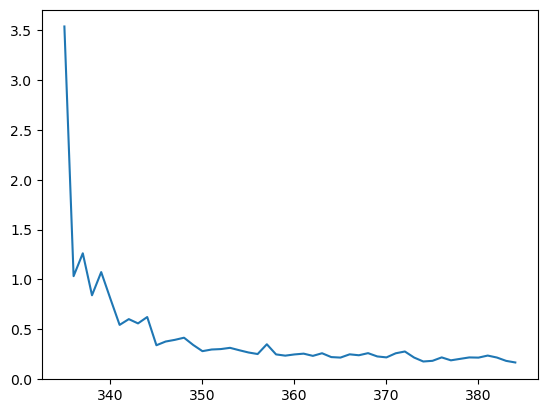

In [55]:
hist[hist['example_idx'] == 11]['gap_FW'].plot()

In [19]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.414841
True     0.106524
Name: gap_FW, dtype: float64

Mean FW iterations: 23.9


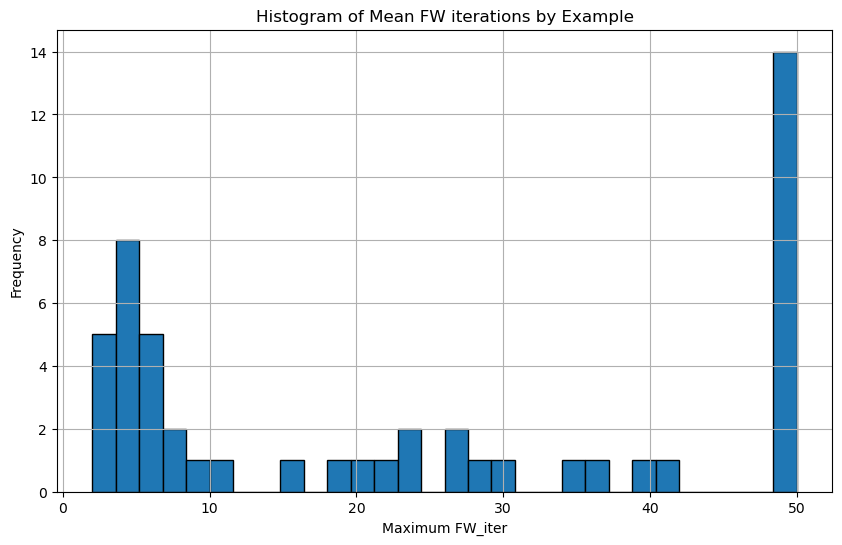

In [43]:
num_iters = hist_dfs[0].groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Mean FW iterations by Example')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [40]:
final_hist['success'].mean()

0.89

In [41]:
final_hist['FW_iter'].mean()

8.42

In [31]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.62

In [28]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.0258064516129033

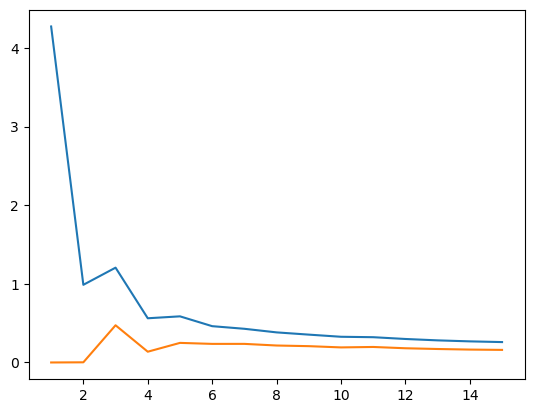

In [7]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

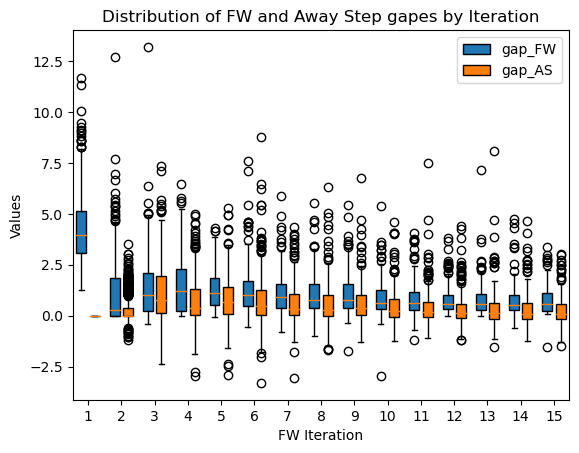

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


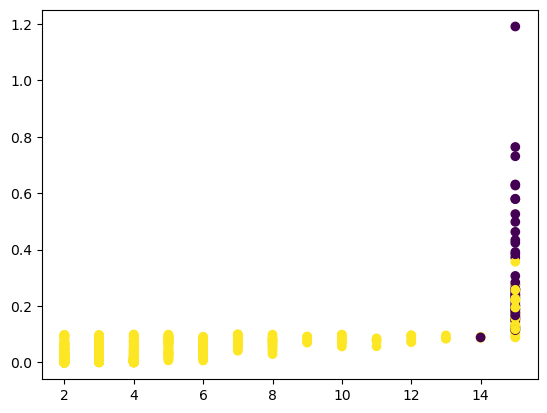

In [15]:
plt.scatter(final_hist['FW_iter'],final_hist['gap_FW'], c=final_hist['success'])

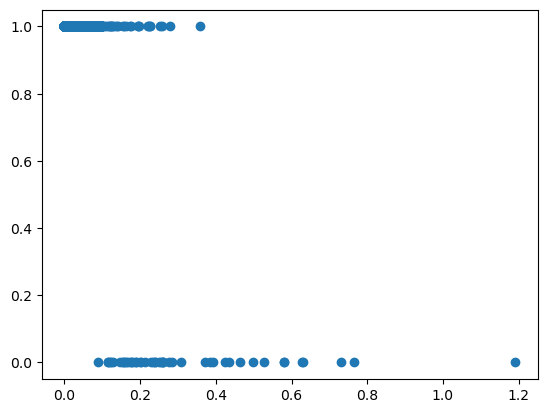

In [16]:
plt.scatter(final_hist['gap_FW'], final_hist['success'])

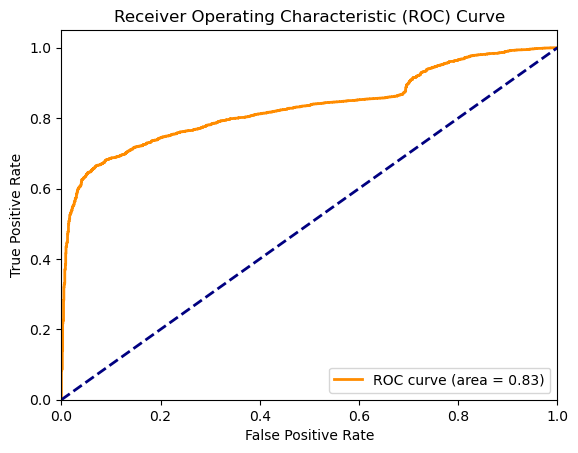

In [ ]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

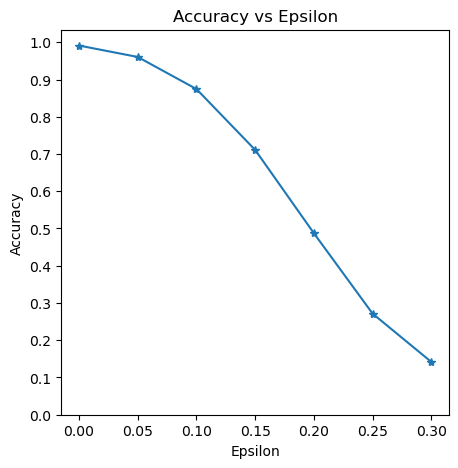

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

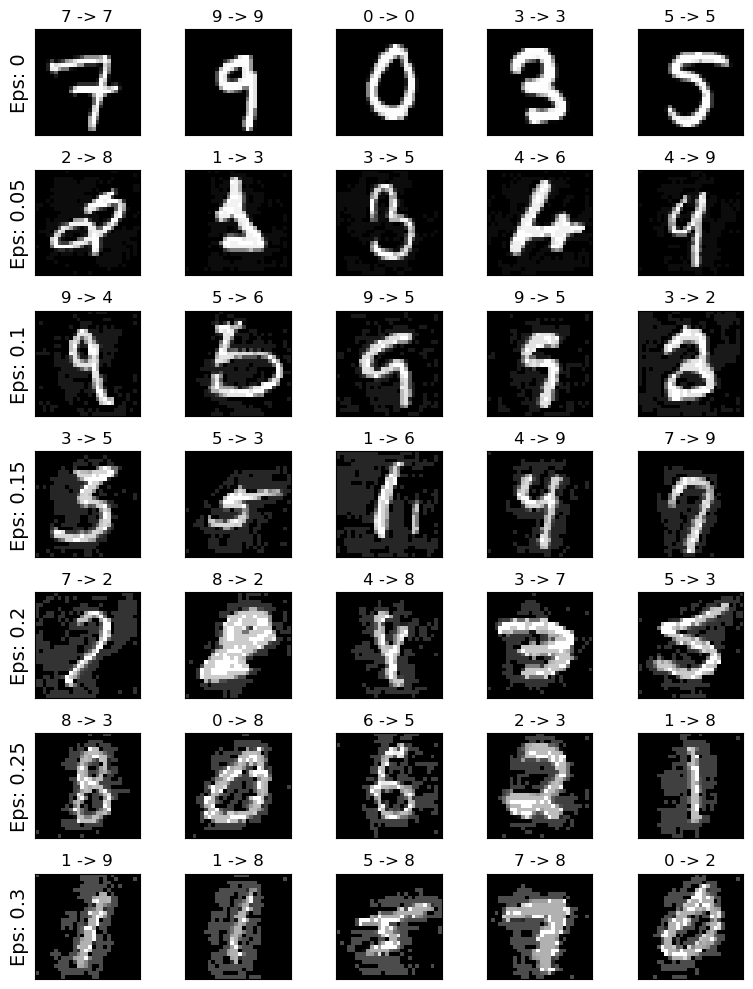

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()